In [116]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# installing important Libraries

In [117]:
# Here we are importing Yolo Library 
# and importing Pytorch engine.

!pip install -U ultralytics --quiet

import os
import warnings
warnings.filterwarnings("ignore")

os.environ["YOLO_VERBOSE"] = "False"

from ultralytics import YOLO
import torch

print("YOLO ready")
print("CUDA available:", torch.cuda.is_available())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.3 MB/s eta 0:00:00a 0:00:01
YOLO ready
CUDA available: True


# Visualizing Our Dataset Images

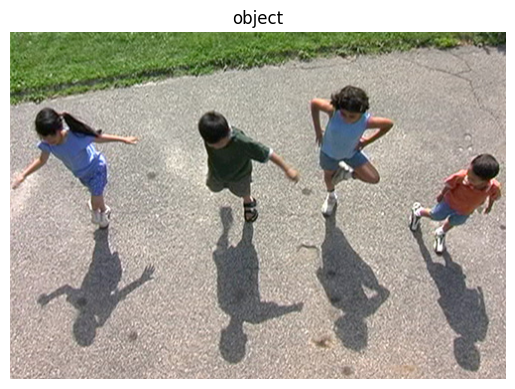

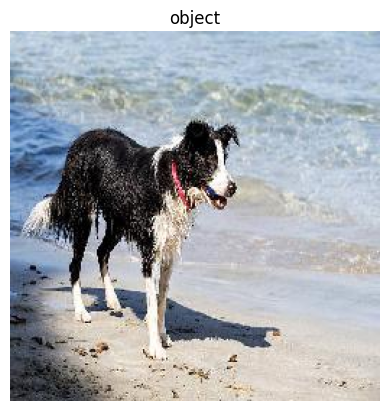

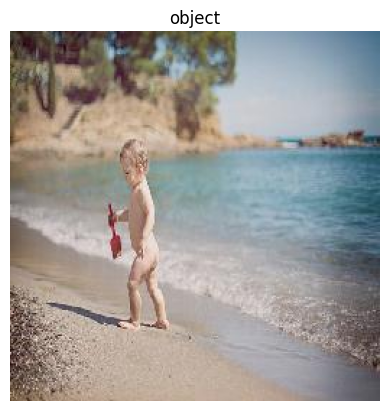

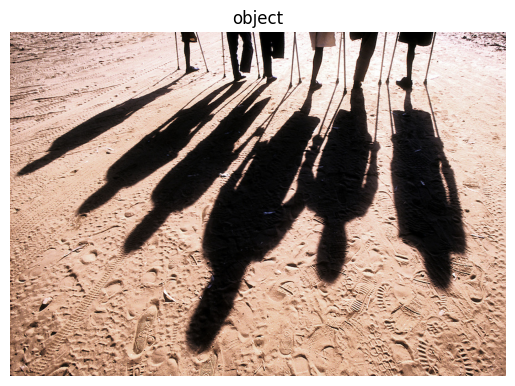

In [118]:
import os, random, matplotlib.pyplot as plt, matplotlib.image as mpimg
G = "/kaggle/input/s-d-3000/SD-3000/SD-3000/train/images"
for i in random.sample(os.listdir(G), 4):
    plt.imshow(mpimg.imread(os.path.join(G, i)), cmap='gray')
    plt.title("object")
    plt.axis('off')
    plt.show()

# Directing Which Label Id Belongs To Which Class

In [119]:


%%writefile /kaggle/working/data.yaml
path: /kaggle/working/SD-3000

train: train/images
val: val/images
test: test/images

nc: 4

names:
  - cow_shadow
  - dog_shadow
  - gun_shadow
  - human_shadow



Overwriting /kaggle/working/data.yaml


# Our Data.yaml 

In [120]:
!cat /kaggle/working/data.yaml

path: /kaggle/working/SD-3000

train: train/images
val: val/images
test: test/images

nc: 4

names:
  - cow_shadow
  - dog_shadow
  - gun_shadow
  - human_shadow



# Our Dataset in Train/Validation/Test

In [121]:
import os
base_path    =  "/kaggle/input/s-d-3000/SD-3000/SD-3000"

train_images = os.listdir(os.path.join(base_path,"train/images"))
val_images   = os.listdir(os.path.join(base_path,"val/images"))
test_images  = os.listdir(os.path.join(base_path,"test/images"))

print("Train images:", len(train_images))
print("Test images:" , len(test_images))
print("Val images:"  ,len(val_images))
print("Total images:" ,len(train_images) + len(test_images) + len(val_images))

Train images: 2100
Test images: 451
Val images: 451
Total images: 3002


# Our Images and their Labels

In [122]:
import os

base = "/kaggle/input/s-d-3000/SD-3000/SD-3000"

for split in ["train", "val", "test"]:
    img_count = len(os.listdir(f"{base}/{split}/images"))
    lbl_count = len(os.listdir(f"{base}/{split}/labels"))
    print(f"{split.upper()} : images = {img_count}, labels = {lbl_count}")


TRAIN : images = 2100, labels = 1929
VAL : images = 451, labels = 415
TEST : images = 451, labels = 429


# Copying our Dataset into kaggle Working 

In [ ]:
import shutil
import os

dest = "/kaggle/working/SD-3000"

# remove if already exists
if os.path.exists(dest):
    shutil.rmtree(dest)

shutil.copytree(
    "/kaggle/input/s-d-3000/SD-3000/SD-3000",
    dest
)

print("DONE")



In [ ]:
import os

os.listdir("/kaggle/working")


# Removing unlabelled images 

In [ ]:
import os

# WORKING dataset  base path
base = "/kaggle/working/SD-3000"

#  Train, Validation, Test  naam
splits = ["train", "val", "test"]

#  
for split in splits:

    # images folder  path
    img_dir = base + "/" + split + "/images"
    
    # labels folder  path
    lbl_dir = base + "/" + split + "/labels"

    #  list of all  image files 
    images = os.listdir(img_dir)
    
    #  all label files list
    labels = os.listdir(lbl_dir)

    removed = 0  # how many images are deleted 

    #  to delete  image check karna
    for img in images:
        # image ka naam (extension hata ke)
        name = img.split(".")[0]

        # agar us image ka label nahi mila
        if name + ".txt" not in labels:
            # image delete kar do
            os.remove(img_dir + "/" + img)
            removed += 1

    #  Result print kar do
    print(split.upper(), ": removed unlabeled images =", removed)

print("DATASET CLEAN DONE")


# Importing Pytorch & YOLO Pretrained Model

In [ ]:
from ultralytics import YOLO
import torch
model = YOLO("yolov8n.pt")


In [ ]:
# important points :
# During training, the model learns by matching
# each image with its label file.
# The label file contains four values
# that describe how well the shadow fits
# inside the image, including its position and size.
# Using these values, the model learns two things
# at the same time: which shadow class the image belongs
# to (cow, dog, gun, or human) and how accurately
# the shadow region fits the object in the image.
# By repeatedly comparing its predictions
# with the given labels, the model improves
# both its shadow localization (fit) and correct
# class identification.¶

# Training Starts

In [ ]:
model.train(
    data="/kaggle/working/data.yaml",
    epochs=100,
    imgsz=640,
    batch=16,
    patience=20
)


# Loading our Trained best Model 

In [ ]:
from ultralytics import YOLO
model = YOLO("/kaggle/working/runs/detect/train/weights/best.pt")


# Validation Accuracy 
 

In [ ]:
metrics = model.val(data="/kaggle/working/data.yaml")


# Test Accuracy 

In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")
os.environ["YOLO_VERBOSE"] = "False"

results = model.predict(
    source="/kaggle/input/s-d-3000/SD-3000/SD-3000/test/images",
    imgsz=640,
    conf=0.25,
    save=True,
    verbose=False
)

In [ ]:
from ultralytics import YOLO

model = YOLO("/kaggle/working/runs/detect/train/weights/best.pt")

metrics = model.val(
    data="/kaggle/working/data.yaml",
    split="test",     # 🔥 TEST SET
    imgsz=640,
    conf=0.25
)


In [ ]:
!ls /kaggle/input/s-d-3000/SD-3000/SD-3000/test


In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")
os.environ["YOLO_VERBOSE"] = "False"



metrics = model.val(
    conf=0.1,
    verbose=False
)






In [ ]:
model.val()



In [ ]:
!cat /kaggle/input/s-d-3000/SD-3000/SD-3000/data.yaml


In [ ]:
%%writefile data_kaggle.yaml
path: /kaggle/input/s-d-3000/SD-3000/SD-3000

train: train/images
val: valid/images
test: test/images

names:
  0: cow_shadow
  1: dog_shadow
  2: gun_shadow
  3: gun_shadow
  4: human_shadow


In [ ]:
!ls /kaggle/input/s-d-3000/SD-3000/SD-3000


In [ ]:
!ls /kaggle/input/s-d-3000/SD-3000/SD-3000/val


In [ ]:
!cat /kaggle/input/s-d-3000/SD-3000/SD-3000/data.yaml


In [ ]:
%%writefile data_kaggle.yaml
path: /kaggle/input/s-d-3000/SD-3000/SD-3000

train: train/images
val: val/images
test: test/images

names:
  0: cow_shadow
  1: dog_shadow
  2: gun_shadow
  3: human_shadow


In [ ]:
model.val(
    data="data_kaggle.yaml",
    split="test",
    conf=0.05,        # aur kam
    iou=0.45,
    imgsz=832,
    plots=True
)


In [ ]:
# open any test label file
!head test/labels/*.txt


In [ ]:
!ls

In [ ]:
!ls /kaggle/working/SD-3000/test


In [ ]:
!rm /kaggle/working/SD-3000/test/labels.cache


In [ ]:
model.val(
    data="data_kaggle.yaml",
    split="test",
    conf=0.1,
    imgsz=832,
    plots=True
)
